In [503]:
import mesa
from functional import seq
import random

from dataclasses import dataclass

In [504]:
from typing import Tuple, Optional, List, Any, Dict

In [505]:
import matplotlib.pyplot as plt
import numpy as np

In [506]:
import networkx as nx
import json

# Locations

In [507]:
@dataclass
class Hotel():
    id: int
    cost: float
    max_capacity: int
    occupied: int = 0

    # stats
    new_rev: int = 0
    new_revenue: int = 0
    total_revenue: int = 0

    def remaining_capacity(self) -> int:
        return self.max_capacity - self.occupied
    
   

In [508]:
@dataclass
class ShortTermHousing():
    id: int
    cost: float
    max_capacity: int
    occupied: int = 0

    # stats
    new_rev: int = 0
    new_revenue: int = 0
    total_revenue: int = 0

    def remaining_capacity(self) -> int:
        return self.max_capacity - self.occupied

In [509]:
@dataclass
class PointOfInterest():
    id: int
    cost: float
    max_capacity: int
    occupied: int = 0


    # stats
    visit: int = 0
    total_visit: int = 0
    
    new_revenue: int = 0
    total_revenue: int = 0


    def remaining_capacity(self) -> int:
        return self.max_capacity - self.occupied

# Tourist

In [510]:
class Tourist(mesa.Agent):
    def __init__(self, unique_id: int, model, loc: int, trip_length: int):
        super().__init__(unique_id, model)
        self.loc: int = loc
        self.hotel: Optional[Hotel] = None
        self.trip_length: int = trip_length
        self.remaining_life: int = trip_length

        self.poi :Optional[PointOfInterest] = None

        self.satisfaction: int = 0

    def step(self):
        self.remaining_life -= 1

        if self.hotel is None and self.remaining_life >= 3:
            # Try to find a hotel with available capacity
            hotels = (
                seq(self.model.hotels)
                .filter(lambda h: h.remaining_capacity() > 0)  # Ensure rooms are available
                .list()
            )

            # If no hotels are available, try short-term rentals
            if len(hotels) == 0:
                short_terms = (
                    seq(self.model.short_term[True])
                    .filter(lambda st: st.remaining_capacity() > 0)
                    .list()
                )

                # If a short-term rental is available, book it
                if len(short_terms) > 0:
                    random_index = random.randint(0, len(short_terms) - 1)
                    self.hotel = short_terms[random_index]
                    self.hotel.occupied += 1
                    self.hotel.new_rev += 1
                    self.hotel.total_rev += 1
                    return
                else:
                    # If neither hotel nor short-term rentals are available, the tourist leaves
                    self.remaining_life = -1
                    return

            # If hotels are available, book a room
            random_index = random.randint(0, len(hotels) - 1)
            self.hotel = hotels[random_index]
            self.hotel.occupied += 1
            self.hotel.new_rev += 1
            self.hotel.total_rev += 1
            return

        # Explore POI if the tourist has a hotel
        random_index = random.randint(0, len(self.model.pois) - 1)
        poi = self.model.pois[random_index]

        # Travel logic
        poi.occupied += 1
        poi.visit += 1

        if self.poi is not None:
            self.poi.occupied -= 1

        match (self.hotel, self.poi):
            case (None, None):
                # Edge case, just teleport to new POI
                pass
            case (None, start) | (start, None) | (_, start):
                path = find_shortest_path(self.model.graph, str(start.id), str(poi.id))
                dist = calculate_path_length(self.model.graph, path)

                self.model.road_traveled += dist
                self.model.co2_emissions[-1]["car"] += dist * 130.0

        self.poi = poi

    def go_home(self):
        # Travel back to hotel
        if self.poi is not None:
            self.poi.occupied -= 1

        match (self.hotel, self.poi):
            case (None, None) | (None, _):
                # Edge case, just teleport to new POI
                pass
            case (end, start):
                path = find_shortest_path(self.model.graph, str(start.id), str(end.id))
                dist = calculate_path_length(self.model.graph, path)

                self.model.road_traveled += dist
                self.model.co2_emissions[-1]["car"] += dist * 130.0

        self.poi = None


## Growth Models

In [511]:
@dataclass
class ConstantTouristInflow():
    rate: int

    trip_length: int
    
    def new_pops(self) -> int:
        return self.rate
    def new_tourist(self, id, model) -> Tourist:
        return Tourist(id, model, 0, self.trip_length)

In [512]:
import random
@dataclass
class RandomTouristInflow:
    mean_rate: float
    stddev_rate: float

    mean_trip_length: float
    stddev_trip_length: float

    def new_pops(self) -> int:
        # Generate a random number of tourists based on a normal distribution
        return max(0, int(random.gauss(self.mean_rate, self.stddev_rate)))

    def new_tourist(self, id: int, model, i: int = 1) -> List[Tourist]:
        return Tourist(id, model, 0, max(1, int(random.gauss(self.mean_trip_length, self.stddev_trip_length))))

In [513]:
@dataclass
class SeasonalTouristInflow:
    inflows: List[RandomTouristInflow]
    season_lengths: List[int]

    counter: int = 0

    def new_pops(self) -> int:
        self.counter= (self.counter+1)%sum(self.season_lengths)

        current_season = max(
            (seq(self.season_lengths)
                .enumerate()
                .filter(lambda x: self.counter < sum(self.season_lengths[:x[0] + 1]))
                .first()
            )[0],
            0
        )


        return self.inflows[current_season].new_pops()

    def new_tourist(self, id: int, model, i: int = 0) -> List[Tourist]:
        
        current_season = max(
            (seq(self.season_lengths)
                .enumerate()
                .filter(lambda x: self.counter < sum(self.season_lengths[:x[0] + 1]))
                .first()
            )[0],
            0
        )

        return self.inflows[current_season].new_tourist(id, model)


In [514]:
@dataclass
class CruiseShipInflow:
    group_size: int
    trip_length: int
    arrival_interval: int

    counter: int = 0

    def new_pops(self) -> int:
        self.counter = (self.counter + 1 ) % self.arrival_interval
        if self.counter  == 0:
            return self.group_size
        return 0

    def new_tourist(self, id: int, model) -> List[Tourist]:
        return Tourist(id, model, 0, self.trip_length)


In [515]:

@dataclass
class UnionInflow:
    inflows: List[Any]

    def new_pops(self) -> int:
        return seq(self.inflows).map(lambda i: i.new_pops()).sum()

    def new_tourist(self, id: int, model) -> List[Tourist]:
        tourists = []
        for inflow in self.inflows:
            tourists.extend(inflow.new_tourist(id, model, i = i))
        return tourists

# Mapping

In [516]:
@dataclass
class Node:
    id: int
    lat: float
    lon: float

In [517]:
import tripy
from dataclasses import field
from functional import seq
from pyproj import Proj, Transformer

@dataclass(unsafe_hash=True)
class Building:
    id: int = field(compare=True) 
    nodes: List[Node] = field(compare=False) 
    tags: Dict[str, Any] = field(compare=False) 

    def __post_init__(self):
        self.transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

    def triangulate(self) -> List[Tuple[Tuple[float, float]]]:
        return tripy.earclip(
            seq(self.nodes)
                .map(lambda x: (x.lon, x.lat))
                .take(len(self.nodes) - 1)
                .list()
            )
    
    def get_centroid(self) -> Tuple[float, float]:
        triangles = self.triangulate()
        total_area = 0
        centroid_x = 0
        centroid_y = 0

        for triangle in triangles:
            p1, p2, p3 = triangle
            
            # Calculate the centroid of the triangle
            tri_centroid_x = (p1[0] + p2[0] + p3[0]) / 3
            tri_centroid_y = (p1[1] + p2[1] + p3[1]) / 3

            # Calculate the area of the triangle
            tri_area = self._triangle_area(p1, p2, p3)

            # Accumulate weighted centroids
            centroid_x += tri_centroid_x * tri_area
            centroid_y += tri_centroid_y * tri_area
            total_area += tri_area

        # Final centroid is the weighted average of all triangle centroids
        if total_area == 0:
            raise ValueError("The building's area is zero. Centroid cannot be calculated.")

        return centroid_x / total_area, centroid_y / total_area
    
    def contains(self, lon: float, lat: float) -> bool:# Get the triangles from the triangulate method
        triangles = self.triangulate()

        for triangle in triangles:
            if self._point_in_triangle((lon, lat), triangle):
                return True
        return False
    
    def get_area(self) -> float:
        """Calculate the total area of the building in square meters."""
        triangles = self.triangulate()
        total_area = 0

        for triangle in triangles:
            # Convert triangle vertices from lat/lon to meters
            p1 = self._to_meters(triangle[0])
            p2 = self._to_meters(triangle[1])
            p3 = self._to_meters(triangle[2])

            # Add the triangle's area in square meters
            total_area += self._triangle_area(p1, p2, p3)

        return total_area

    def _to_meters(self, point: Tuple[float, float]) -> Tuple[float, float]:
        """Convert a point (lon, lat) to meters using the UTM projection."""
        lon, lat = point
        return self.transformer.transform(lon, lat)
    
    @staticmethod
    def _triangle_area(p1: Tuple[float, float], p2: Tuple[float, float], p3: Tuple[float, float]) -> float:
        x1, y1 = p1
        x2, y2 = p2
        x3, y3 = p3
        return abs((x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2)) / 2)

    @staticmethod
    def _point_in_triangle(point: Tuple[float, float], triangle: Tuple[Tuple[float, float]]):
        p1, p2, p3 = triangle
        
        total_area = Building._triangle_area(p1, p2, p3)

        area1 = Building._triangle_area(point, p2, p3)
        area2 = Building._triangle_area(p1, point, p3)
        area3 = Building._triangle_area(p1, p2, point)

        return abs(total_area - (area1 + area2 + area3)) < 1e-9

In [518]:
def load_from_json(file_path: str) -> Tuple[nx.Graph, List[Node], Dict[str, List[Building]]]:
    with open(file_path, "r") as file:
        data = json.load(file)
    
    # Reconstruct the graph from the data
    graph_data = data["graph"]
    graph: nx.Graph = nx.node_link_graph(graph_data)  # Converts the node-link format back into a NetworkX graph
    
    # Reconstruct nodes from the data
    nodes = (seq(data["nodes"].items())
        .map(lambda x: (int(x[0]), Node(**x[1])))
        .dict()
    )
    
    # Reconstruct buildings from the data
    buildings = {}
    for key, building_list in data["buildings"].items():
        building_objs = (seq(building_list)
            .map(lambda building_data: Building(
                id=building_data["id"],
                nodes=[Node(**node_data) for node_data in building_data["nodes"]],
                tags=building_data["tags"])
            )
            .filter(lambda building: graph.has_node(str(building.id)))
            .list()
        )
        buildings[key] = building_objs
    
    return graph, nodes, buildings



In [519]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """
    Calculate the Haversine distance between two points on the Earth.
    Returns the distance in kilometers.
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    # Radius of Earth in kilometers (use 6371 for km or 3958.8 for miles)
    radius = 6371.0
    distance = radius * c
    return distance

shortest_path_cache = dict()
def find_shortest_path(G: nx.Graph, start_node_id: int, end_node_id: int) -> List[int]:
    """
    Finds the shortest path between two nodes in the graph based on Haversine distance.
    Returns the list of node IDs representing the shortest path from start_node_id to end_node_id.
    """
    # Define a custom weight function for the edges based on Haversine distance
    cache_key = (start_node_id, end_node_id)
    if cache_key in shortest_path_cache:
        return shortest_path_cache[cache_key]
    def haversine_weight(u, v, data):
        lat1, lon1 = G.nodes[u]['lat'], G.nodes[u]['lon']
        lat2, lon2 = G.nodes[v]['lat'], G.nodes[v]['lon']
        return haversine(lat1, lon1, lat2, lon2)
    
    try:
        # Using Dijkstra's algorithm with Haversine distance as weight
        shortest_path = nx.dijkstra_path(G, source=start_node_id, target=end_node_id, weight=haversine_weight)
        shortest_path_cache[cache_key] = shortest_path
        return shortest_path
    except nx.NetworkXNoPath:
        print(f"No path found between node {start_node_id} and node {end_node_id}.")
        shortest_path_cache[cache_key] = []
        return []

path_length_cache = dict()
def calculate_path_length(G: nx.Graph, path: List[int]) -> float:
    """
    Calculate the total Haversine distance of a given path in the graph.
    Returns the distance in kilometers.
    """
    path_cache_key = tuple(path)
    if path_cache_key in path_length_cache:
        return path_length_cache[path_cache_key]
    if len(path) < 2:
        return 0.0  # No distance to compute for a path with less than 2 nodes

    total_distance = 0.0
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        lat1, lon1 = G.nodes[u]['lat'], G.nodes[u]['lon']
        lat2, lon2 = G.nodes[v]['lat'], G.nodes[v]['lon']
        total_distance += haversine(lat1, lon1, lat2, lon2)
    path_length_cache[path_cache_key] = total_distance
    return total_distance

# Tourist

In [520]:
class Tourist(mesa.Agent):
    def __init__(self, unique_id: int, model, loc: int, trip_length: int):
        super().__init__(unique_id, model)
        self.loc: int = loc
        self.hotel: Optional[Hotel] = None
        self.trip_length: int = trip_length
        self.remaining_life: int = trip_length

        self.poi: Optional[PointOfInterest] = None

        self.satisfaction: int = 0

    def step(self):
        self.remaining_life -= 1

        # Attempt to find accommodation
        if self.hotel is None and self.remaining_life >= 3:
            # Try to find a hotel with available capacity
            hotels = (
                seq(self.model.hotels)
                .filter(lambda h: h.remaining_capacity() > 0)
                .list()
            )

            # If no hotels are available, try short-term rentals
            if not hotels:
                short_terms = (
                    seq(self.model.short_term[True])
                    .filter(lambda st: st.remaining_capacity() > 0)
                    .list()
                )

                if short_terms:
                    random_index = random.randint(0, len(short_terms) - 1)
                    self.hotel = short_terms[random_index]
                    self.hotel.occupied += 1
                    self.hotel.new_revenue += self.hotel.cost
                    self.hotel.total_revenue += self.hotel.cost
                    return
                else:
                    # No accommodation available, tourist leaves
                    self.remaining_life = -1
                    return

            # Book a room in a hotel
            random_index = random.randint(0, len(hotels) - 1)
            self.hotel = hotels[random_index]
            self.hotel.occupied += 1
            self.hotel.new_revenue += self.hotel.cost * self.trip_length
            self.hotel.total_revenue += self.hotel.cost * self.trip_length
            return

        # Explore a POI if the tourist has a hotel
        random_index = random.randint(0, len(self.model.pois) - 1)
        poi: PointOfInterest = self.model.pois[random_index]

        if poi.remaining_capacity() > 0:
            # Visit the POI
            poi.occupied += 1
            poi.visit += 1
            poi.new_revenue += poi.cost
            poi.total_revenue += poi.cost

            # Update previous POI if applicable
            if self.poi is not None:
                self.poi.occupied -= 1

            # Handle travel between POIs and update CO2 emissions
            match (self.hotel, self.poi):
                case (None, None):
                    # Edge case: teleport to new POI
                    pass
                case (None, start) | (start, None) | (_, start):
                    path = find_shortest_path(self.model.graph, str(start.id), str(poi.id))
                    dist = calculate_path_length(self.model.graph, path)

                    self.model.road_traveled += dist
                    self.model.co2_emissions[-1]["car"] += dist * 130.0

            self.poi = poi

    def go_home(self):
        # Travel back to the hotel
        if self.poi is not None:
            self.poi.occupied -= 1

        match (self.hotel, self.poi):
            case (None, None) | (None, _):
                # Edge case: teleport to new POI
                pass
            case (end, start):
                path = find_shortest_path(self.model.graph, str(start.id), str(end.id))
                dist = calculate_path_length(self.model.graph, path)

                self.model.road_traveled += dist
                self.model.co2_emissions[-1]["car"] += dist * 130.0

        self.poi = None


## Growth Models

In [521]:
@dataclass
class ConstantTouristInflow():
    rate: int

    trip_length: int
    
    def new_pops(self) -> int:
        return self.rate
    def new_tourist(self, id, model) -> Tourist:
        return Tourist(id, model, 0, self.trip_length)

In [522]:
import random
@dataclass
class RandomTouristInflow:
    mean_rate: float
    stddev_rate: float

    mean_trip_length: float
    stddev_trip_length: float

    def new_pops(self) -> int:
        # Generate a random number of tourists based on a normal distribution
        return max(0, int(random.gauss(self.mean_rate, self.stddev_rate)))

    def new_tourist(self, id: int, model, i: int = 1) -> List[Tourist]:
        return Tourist(id, model, 0, max(1, int(random.gauss(self.mean_trip_length, self.stddev_trip_length))))

In [523]:
@dataclass
class SeasonalTouristInflow:
    inflows: List[RandomTouristInflow]
    season_lengths: List[int]

    counter: int = 0

    def new_pops(self) -> int:
        self.counter= (self.counter+1)%sum(self.season_lengths)

        current_season = max(
            (seq(self.season_lengths)
                .enumerate()
                .filter(lambda x: self.counter < sum(self.season_lengths[:x[0] + 1]))
                .first()
            )[0],
            0
        )


        return self.inflows[current_season].new_pops()

    def new_tourist(self, id: int, model, i: int = 0) -> List[Tourist]:
        
        current_season = max(
            (seq(self.season_lengths)
                .enumerate()
                .filter(lambda x: self.counter < sum(self.season_lengths[:x[0] + 1]))
                .first()
            )[0],
            0
        )

        return self.inflows[current_season].new_tourist(id, model)


In [524]:
@dataclass
class CruiseShipInflow:
    group_size: int
    trip_length: int
    arrival_interval: int

    counter: int = 0

    def new_pops(self) -> int:
        self.counter = (self.counter + 1 ) % self.arrival_interval
        if self.counter  == 0:
            return self.group_size
        return 0

    def new_tourist(self, id: int, model) -> List[Tourist]:
        return Tourist(id, model, 0, self.trip_length)


In [525]:

@dataclass
class UnionInflow:
    inflows: List[Any]

    def new_pops(self) -> int:
        return seq(self.inflows).map(lambda i: i.new_pops()).sum()

    def new_tourist(self, id: int, model) -> List[Tourist]:
        tourists = []
        for inflow in self.inflows:
            tourists.extend(inflow.new_tourist(id, model, i = i))
        return tourists

In [526]:
graph, nodes, buildings = load_from_json("data.json")
print("Data loaded from output.json")
print(graph)
print(nodes)
print(buildings)

Data loaded from output.json
Graph with 1865 nodes and 1997 edges
{65662330: Node(id=65662330, lat=58.3572959, lon=-134.5006807), 65662334: Node(id=65662334, lat=58.3575501, lon=-134.4999879), 65662335: Node(id=65662335, lat=58.3580109, lon=-134.4986801), 65662336: Node(id=65662336, lat=58.3584349, lon=-134.4974103), 65662337: Node(id=65662337, lat=58.358785, lon=-134.4960942), 65662340: Node(id=65662340, lat=58.3589842, lon=-134.4953102), 65662343: Node(id=65662343, lat=58.3590563, lon=-134.4950097), 65662344: Node(id=65662344, lat=58.3591421, lon=-134.4946605), 65662345: Node(id=65662345, lat=58.3592024, lon=-134.4944003), 65662347: Node(id=65662347, lat=58.3592507, lon=-134.4942126), 65662877: Node(id=65662877, lat=58.3614442, lon=-134.5154038), 65662878: Node(id=65662878, lat=58.3612941, lon=-134.5155917), 65662880: Node(id=65662880, lat=58.3612106, lon=-134.5159078), 65662882: Node(id=65662882, lat=58.3611788, lon=-134.5165755), 65662883: Node(id=65662883, lat=58.3611175, lon=-134

# Model

In [536]:
class Model(mesa.Model):
    def __init__(self, nodes, graph, buildings, inflow_model, property_tax: float, business_tax: float):
        self.hotels: List[Hotel] = []
        self.pois: List[PointOfInterest] = []

        self.property_tax = property_tax
        self.business_tax = business_tax

        self.rev_stats: List[Dict[str, float]] = []

        self.short_term: Dict[bool, List[ShortTermHousing]] = {
            False: [],
            True: []
        }

        self.tourists: List[Tourist] = []

        self.schedule = mesa.time.RandomActivation(self)

        self.inflow = inflow_model

        # Stats
        self.hotel_stats = []
        self.poi_stats = []
        
        self.road_traveled = 0.

        self.co2_emissions = [{
            "car": 0,
            "air_plane": 0,
            "boat": 0,
        }]

        self.graph = graph
        self.nodes = nodes
        self.buildings = buildings

        print(len(buildings["residential"]))
        for residential in buildings["residential"]:
            self.short_term[False].append(
                ShortTermHousing(int(residential.id), 100, 5)
            )
        self.total_revenue = 0
        self.cost_infra = 0
        self.cost_env = 0

        print(len(buildings["lodging"]))
        for lodge in buildings["lodging"]:
            area = lodge.get_area()

            max_capacity = max(30, int(area / 1.5 * 0.01))
            self.hotels.append(Hotel(int(lodge.id), 100, max_capacity))

        pois_tag: List[str] = ["store", "restaurant", "night_club", "museum", "city_hall", "bar", "art_gallery", "tourist_attraction"]
        self.pois_building = []
        for tag in pois_tag:
            for building in buildings[tag]:
                area = building.get_area()

                max_capacity = max(10, int(area / 1.5 * 0.01))

                self.pois_building.append(building)
                self.pois.append(PointOfInterest(building.id, 200, max_capacity))

    def update_tourists(self):
        num_tourists = len(self.tourists)
        random_indices = set()

        # Generate a set of unique random indices
        while len(random_indices) < num_tourists:
            random_indices.add(random.randint(0, num_tourists - 1))

        # Access tourists in a random order using the indices
        for index in random_indices:
            tourist = self.tourists[index]
            tourist.step()
    def remove_tourists(self):
        remove_index: list[int] = (seq(self.tourists)
            .enumerate()
            .filter(lambda x: x[1].remaining_life < 0)
            .map(lambda x: x[0])
            .sorted(reverse=True)
            .list()
        )
        for i1 in remove_index:
            if self.tourists[i1].hotel:
                self.tourists[i1].hotel.occupied -=1

            del self.tourists[i1]
    def step(self):
        self.update_tourists()
        self.poi_stats.append(self.get_poi_stats())
        self.update_tourists()
        self.poi_stats.append(self.get_poi_stats())
        self.update_tourists()
        self.poi_stats.append(self.get_poi_stats())

        self.remove_tourists()

        self.hotel_stats.append(self.get_hotel_stats())
        
        self.poi_stats.append(self.get_poi_stats())

        size = self.inflow.new_pops()
        for i in range(size):
            self.tourists.append(self.inflow.new_tourist(i, self))

        self.co2_emissions.append({
            "car": 0,
            "air_plane": 0,
            "boat": 0,
        })

        self.rev_stats.append(
            self.get_rev_stats()
        )

    def get_poi_stats(self) -> Tuple[float, float, float, float]:
        # Calculate total capacity
        total_capacity: int = (seq(self.pois)
            .map(lambda p: p.max_capacity)
            .fold_left(0, lambda acc, next: acc + next)
        )
        # Calculate empty slots (remaining capacity)
        empty_slots: int = (seq(self.pois)
            .map(lambda p: p.remaining_capacity())
            .fold_left(0, lambda acc, next: acc + next)
        )
        # Calculate occupied slots
        occupied_slots: int = (seq(self.pois)
            .map(lambda p: p.occupied)
            .fold_left(0, lambda acc, next: acc + next)
        )
        # Calculate new visits
        new_visits: int = (seq(self.pois)
            .map(lambda p: p.visit)
            .fold_left(0, lambda acc, next: acc + next)
        )
        # Reset new visits for the next time step
        for poi in self.pois:
            poi.visit = 0

        return (total_capacity, empty_slots, occupied_slots, new_visits)
    def get_hotel_stats(self) -> Tuple[float, float, float, float, float]:
        total_capacity: int = (seq(self.hotels)
            .map(lambda h: h.max_capacity)
            .fold_left(0, lambda acc, next: acc + next)
        )

        # Add short-term housing capacity to the total capacity
        total_capacity += (seq(self.short_term[True])
            .map(lambda st: st.max_capacity)
            .fold_left(0, lambda acc, next: acc + next)
        )

        empty_rooms: int = (seq(self.hotels)
            .map(lambda h: h.remaining_capacity())
            .fold_left(0, lambda acc, next: acc + next)
        )

        # Add short-term housing empty rooms
        empty_rooms += (seq(self.short_term[True])
            .map(lambda st: st.remaining_capacity())
            .fold_left(0, lambda acc, next: acc + next)
        )

        occupied_rooms: int = (seq(self.hotels)
            .map(lambda h: h.occupied)
            .fold_left(0, lambda acc, next: acc + next)
        )
        
        # Add short-term housing occupied rooms
        occupied_rooms += (seq(self.short_term[True])
            .map(lambda st: st.occupied)
            .fold_left(0, lambda acc, next: acc + next)
        )

        new_reservations: int = (seq(self.hotels)
            .map(lambda h: h.new_rev)
            .fold_left(0, lambda acc, next: acc + next)
        )
        for hotel in self.hotels:
            hotel.new_rev = 0

        # Add new reservations for short-term rentals
        new_reservations += (seq(self.short_term[True])
            .map(lambda st: st.new_rev)
            .fold_left(0, lambda acc, next: acc + next)
        )
        for hotel in self.short_term[True]:
            hotel.new_rev = 0

        return (total_capacity, empty_rooms, occupied_rooms, new_reservations, total_capacity)  # Return updated total capacity
    
    def plot_hotel_stats(self):
        if not self.hotel_stats:
            print("No stats to plot.")
            return

        stats = np.array(self.hotel_stats)
        time_steps = range(len(stats))

        plt.plot(time_steps, stats[:, 0], label="Total Capacity")
        plt.plot(time_steps, stats[:, 1], label="Empty Rooms")
        plt.plot(time_steps, stats[:, 2], label="Occupied Rooms")
        plt.plot(time_steps, stats[:, 3], label="New Reservations")

        plt.title("Hotel Statistics Over Time")
        plt.xlabel("Time Steps")
        plt.ylabel("Number of Rooms")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_poi_stats(self):
        if not self.poi_stats:
            print("No POI stats to plot.")
            return

        # Convert collected statistics into a NumPy array
        stats = np.array(self.poi_stats)
        time_steps = range(len(stats))

        # Plot the statistics
        plt.plot(time_steps, stats[:, 0], label="Total Capacity")
        plt.plot(time_steps, stats[:, 1], label="Empty Slots")
        plt.plot(time_steps, stats[:, 2], label="Occupied Slots")
        plt.plot(time_steps, stats[:, 3], label="New Visits")

        plt.title("POI Statistics Over Time")
        plt.xlabel("Time Steps")
        plt.ylabel("Number of Visitors")
        plt.legend()
        plt.grid(True)
        plt.show()
    def plot_co2_emissions(self):
        if not self.co2_emissions or not isinstance(self.co2_emissions, list):
            print("No CO2 emissions data to plot.")
            return

        # Example data structure: list of dictionaries with emission values
        co2_car = [emission["car"] for emission in self.co2_emissions]
        co2_airplane = [emission["air_plane"] for emission in self.co2_emissions]
        co2_boat = [emission["boat"] for emission in self.co2_emissions]
        time_steps = range(len(self.co2_emissions))

        plt.plot(time_steps, co2_car, label="Car (grams)")
        plt.plot(time_steps, co2_airplane, label="Airplane (grams)")
        plt.plot(time_steps, co2_boat, label="Boat (grams)")

        plt.title("CO2 Emissions Over Time")
        plt.xlabel("Time Steps")
        plt.ylabel("CO2 Emissions (grams)")
        plt.legend()
        plt.grid(True)
        plt.show()

    def update_short_term_housing(self):
        # Calculate the total capacity and remaining capacity for the entire system
        total_capacity = (
            sum(hotel.max_capacity for hotel in self.hotels) +
            sum(st_h.max_capacity for st_h in self.short_term[True])
        )
        remaining_capacity = (
            sum(hotel.remaining_capacity() for hotel in self.hotels) +
            sum(st_h.remaining_capacity() for st_h in self.short_term[True])
        )

        # If the system is completely full or has no capacity, skip
        if total_capacity == 0:
            print("No capacity available in the system.")
            return

        # Calculate the system-wide fullness ratio
        fullness_ratio = 1 - (remaining_capacity / total_capacity)

        if fullness_ratio < 0.3:  # Example: If less than 30% full, reduce active housing
            for st_house in self.short_term[True][:]:
                # Only deactivate if no one is occupying this short-term housing
                if st_house.occupied == 0:
                    probability = 1 - fullness_ratio  # Higher remaining capacity = higher chance to deactivate
                    if random.random() < probability:
                        self.short_term[False].append(st_house)
                        self.short_term[True].remove(st_house)

        elif fullness_ratio > 0.8:  # Example: If more than 75% full, activate housing
            for st_house in self.short_term[False][:]:
                probability = fullness_ratio  # Higher fullness = higher chance to activate
                if random.random() < probability:
                    self.short_term[True].append(st_house)
                    self.short_term[False].remove(st_house)
    
    def get_rev_stats(self) -> Dict[str, float]:
        """Calculates revenue statistics including business and property tax."""
        # Hotel revenue
        hotel_revenue = sum(hotel.new_revenue for hotel in self.hotels)
        hotel_total_revenue = sum(hotel.total_revenue for hotel in self.hotels)

        # Short-term housing revenue
        short_term_revenue = sum(
            st.new_revenue for st in self.short_term[True]
        )
        short_term_total_revenue = sum(
            st.total_revenue for st in self.short_term[True]
        )

        # POI revenue
        poi_revenue = sum(poi.new_revenue for poi in self.pois)
        poi_total_revenue = sum(poi.total_revenue for poi in self.pois)

        # Business tax contributions
        business_tax_revenue = (
            hotel_revenue + short_term_revenue + poi_revenue
        ) * self.business_tax

        # Property tax contributions (applied to short-term housing and hotels)
        property_tax_revenue = (
            sum(hotel.max_capacity * hotel.cost for hotel in self.hotels)
            + sum(st.max_capacity * st.cost for st in self.short_term[True])
        ) * self.property_tax

        # Total revenue
        total_revenue = (
            hotel_revenue + short_term_revenue + poi_revenue
            + business_tax_revenue + property_tax_revenue
        )

        return {
            "hotel_new_revenue": hotel_revenue,
            "hotel_total_revenue": hotel_total_revenue,
            "short_term_new_revenue": short_term_revenue,
            "short_term_total_revenue": short_term_total_revenue,
            "poi_new_revenue": poi_revenue,
            "poi_total_revenue": poi_total_revenue,
            "business_tax_revenue": business_tax_revenue,
            "property_tax_revenue": property_tax_revenue,
            "total_revenue": total_revenue,
        }

    def plot_rev(self):
        """Plots the revenue breakdown and total revenue over time."""
        rev_stats = [self.get_rev_stats() for _ in range(len(self.hotel_stats))]

        # Extract revenue data for plotting
        total_revenues = [rev["total_revenue"] for rev in rev_stats]
        hotel_new_revenues = [rev["hotel_new_revenue"] for rev in rev_stats]
        short_term_new_revenues = [rev["short_term_new_revenue"] for rev in rev_stats]
        poi_new_revenues = [rev["poi_new_revenue"] for rev in rev_stats]
        business_taxes = [rev["business_tax_revenue"] for rev in rev_stats]
        property_taxes = [rev["property_tax_revenue"] for rev in rev_stats]

        time_steps = range(len(self.hotel_stats))

        # Plot total revenue
        plt.plot(time_steps, total_revenues, label="Total Revenue", color="black", linewidth=2)

        # Plot breakdown of revenues
        plt.plot(time_steps, hotel_new_revenues, label="Hotel New Revenue", linestyle="--")
        plt.plot(time_steps, short_term_new_revenues, label="Short-Term Housing New Revenue", linestyle=":")
        plt.plot(time_steps, poi_new_revenues, label="POI New Revenue", linestyle="-.")
        plt.plot(time_steps, business_taxes, label="Business Tax Revenue", linestyle="-")
        plt.plot(time_steps, property_taxes, label="Property Tax Revenue", linestyle=":")

        # Add labels, legend, and grid
        plt.title("Revenue Statistics Over Time")
        plt.xlabel("Time Steps")
        plt.ylabel("Revenue")
        plt.legend()
        plt.grid(True)

        plt.show()


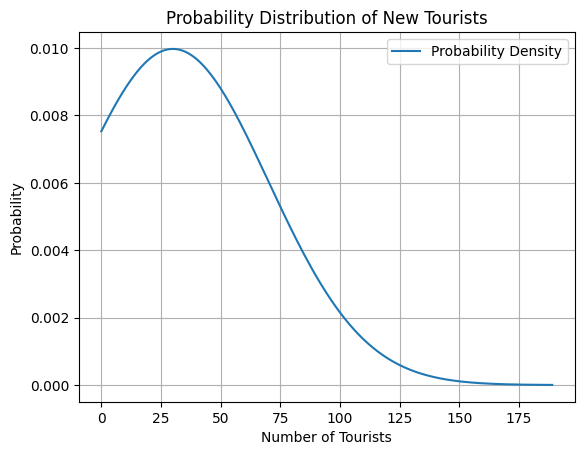

In [537]:

mean_rate=30
stddev_rate=40

x = np.arange(0, mean_rate + 4 * stddev_rate, 1)
y = (1 / (stddev_rate * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean_rate) / stddev_rate) ** 2)
plt.plot(x, y, label="Probability Density")
plt.title("Probability Distribution of New Tourists")
plt.xlabel("Number of Tourists")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.show()

In [538]:
inflow_season_1 = RandomTouristInflow(mean_rate=15, stddev_rate=25, mean_trip_length=30, stddev_trip_length=40)
inflow_season_2 = RandomTouristInflow(mean_rate=5, stddev_rate=5, mean_trip_length=15, stddev_trip_length=25)

# Define the corresponding season lengths
season_lengths = [30*2, 180-30*2]

# Create a SeasonalTouristInflow instance
seasonal_inflow = SeasonalTouristInflow(
    inflows=[inflow_season_1, inflow_season_2],
    season_lengths=season_lengths
)

cruise_ship = CruiseShipInflow(200, 2, 180)

inflows = UnionInflow([seasonal_inflow, cruise_ship])

In [539]:
starter_model=Model(nodes, graph, buildings, seasonal_inflow, 0.1, 0.1)
for i in range(360*2):
    starter_model.step()
    # if i > 360*2:
    #     for inflow in seasonal_inflow.inflows:
    #         inflow.mean_rate=-100
    if i % 30 == 0:
        for inflow in seasonal_inflow.inflows:
            inflow.mean_rate+=5

    if i % 30 == 0:
        starter_model.update_short_term_housing()


275
21


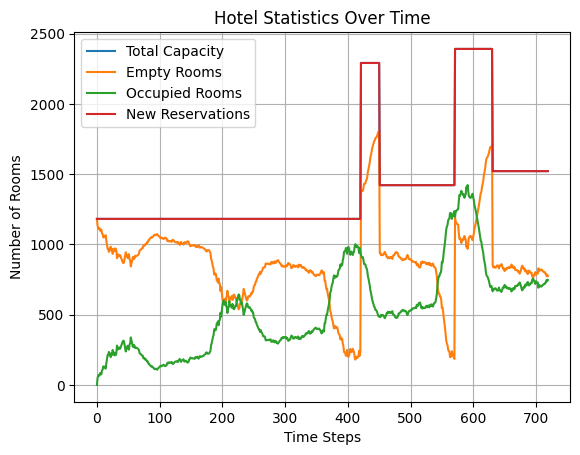

In [540]:
starter_model.plot_hotel_stats()

In [541]:
starter_model.hotel_stats

[(1182, 1182, 0, 0, 1182),
 (1182, 1133, 49, 0, 1182),
 (1182, 1117, 65, 0, 1182),
 (1182, 1111, 71, 0, 1182),
 (1182, 1116, 66, 0, 1182),
 (1182, 1098, 84, 0, 1182),
 (1182, 1102, 80, 0, 1182),
 (1182, 1107, 75, 0, 1182),
 (1182, 1079, 103, 0, 1182),
 (1182, 1074, 108, 0, 1182),
 (1182, 1051, 131, 0, 1182),
 (1182, 1050, 132, 0, 1182),
 (1182, 1057, 125, 0, 1182),
 (1182, 1061, 121, 0, 1182),
 (1182, 1066, 116, 0, 1182),
 (1182, 1026, 156, 0, 1182),
 (1182, 999, 183, 0, 1182),
 (1182, 970, 212, 0, 1182),
 (1182, 969, 213, 0, 1182),
 (1182, 947, 235, 0, 1182),
 (1182, 955, 227, 0, 1182),
 (1182, 969, 213, 0, 1182),
 (1182, 984, 198, 0, 1182),
 (1182, 957, 225, 0, 1182),
 (1182, 969, 213, 0, 1182),
 (1182, 933, 249, 0, 1182),
 (1182, 947, 235, 0, 1182),
 (1182, 957, 225, 0, 1182),
 (1182, 972, 210, 0, 1182),
 (1182, 953, 229, 0, 1182),
 (1182, 970, 212, 0, 1182),
 (1182, 953, 229, 0, 1182),
 (1182, 902, 280, 0, 1182),
 (1182, 916, 266, 0, 1182),
 (1182, 929, 253, 0, 1182),
 (1182, 921, 

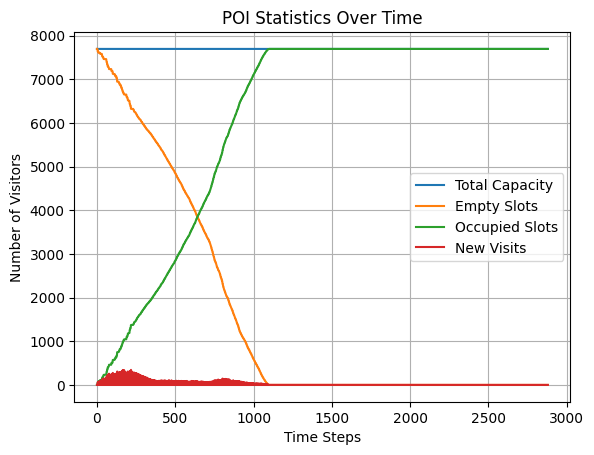

In [542]:
starter_model.plot_poi_stats()

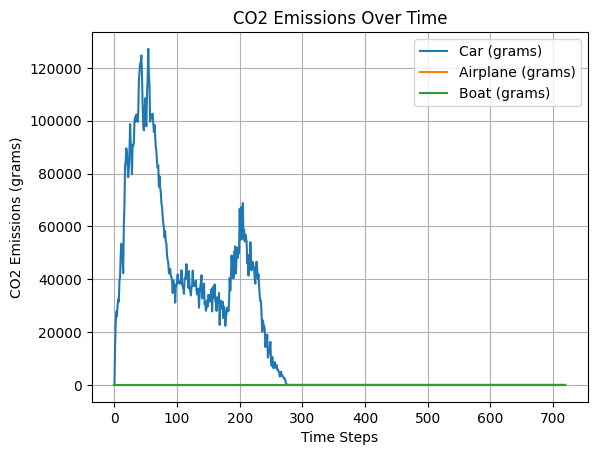

In [543]:
starter_model.plot_co2_emissions()

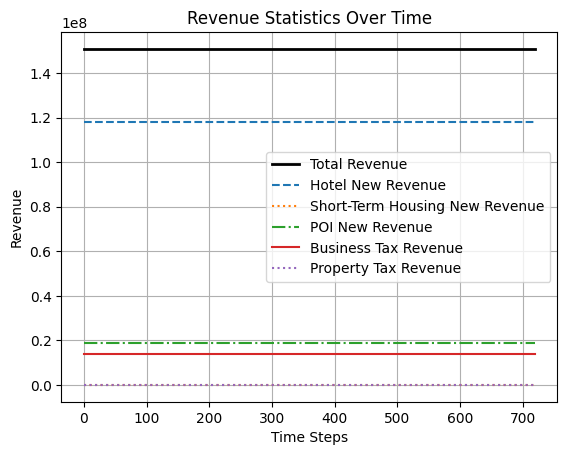

In [544]:
starter_model.plot_rev()